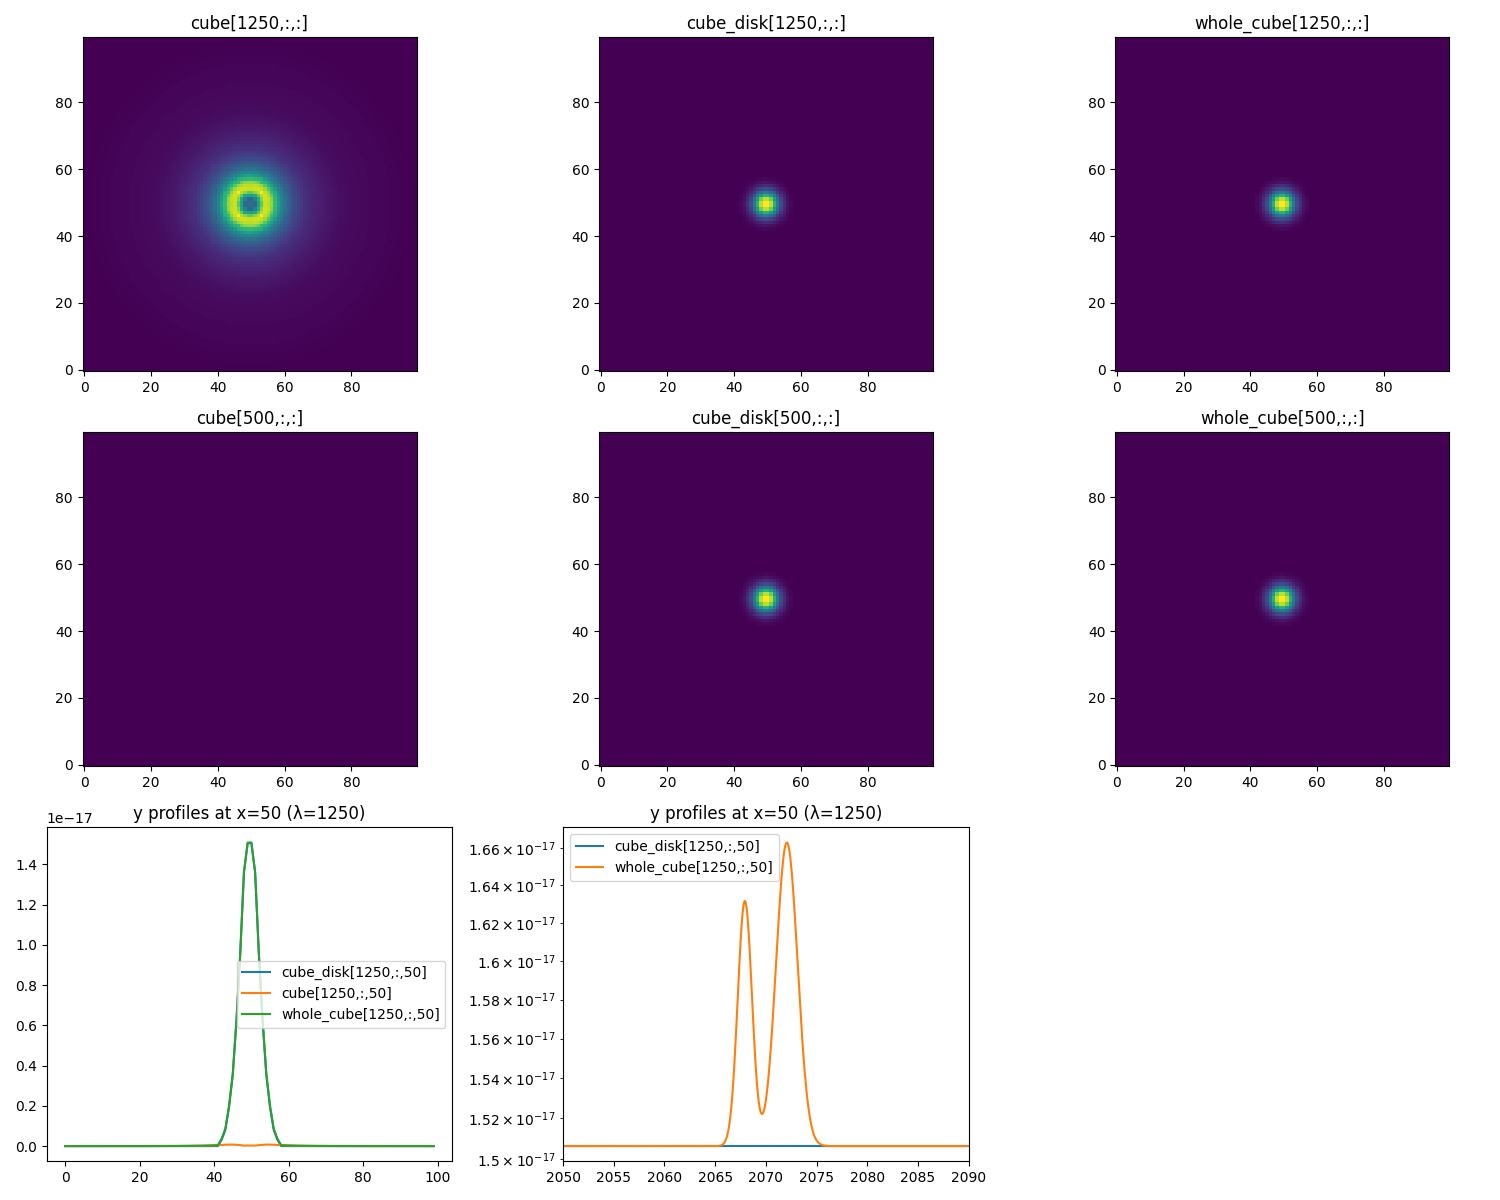

In [1]:
%matplotlib widget
%reload_ext autoreload
import numpy as np
from scipy.interpolate import interp1d
from astropy.cosmology import Planck15 as cosmo
import astropy.units as u
from astropy.table import Table
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.io import fits


# def double_asymmetric_gaussian(v, A_b, v_b, sigma_b, A_r, v_r, sigma_r):
#     return A_b * np.exp(-0.5 * ((v - v_b) / sigma_b) ** 2) + \
#            A_r * np.exp(-0.5 * ((v - v_r) / sigma_r) ** 2)

def double_asymmetric_gaussian(v, A_b, w, speed, sigma_b, A_r,  sigma_r):
    return A_b * np.exp(-0.5 * ((v - w - speed/2) / sigma_b) ** 2) + \
           A_r * np.exp(-0.5 * ((v - w + speed/2) / sigma_r) ** 2)


def generate_radial_profile_cube(whole_profile, disk_profile, redshift, platescale, 
                                 PSF_RMS, size_kpc, wavelength_axis, 
                                 A_b, w, speed, sigma_b, A_r, sigma_r,
                                 disk_continuum_value):
    
    # Output cube dimensions
    ny, nx = 100, 100  # Spatial dimensions
    nw = len(wavelength_axis)
    cube = np.zeros((nw, ny, nx))

    # Convert to angular size (arcsec)
    angular_size_arcsec = size_kpc / cosmo.kpc_proper_per_arcmin(redshift).to(u.kpc / u.arcsec).value

    # 2D spatial grid in arcsec
    x = np.linspace(-platescale * nx / 2, platescale * nx / 2, nx)
    y = np.linspace(-platescale * ny / 2, platescale * ny / 2, ny)
    xx, yy = np.meshgrid(x, y)
    r = np.sqrt(xx**2 + yy**2)

    # Interpolate radial profiles
    whole_profile_interp = interp1d(whole_profile["r_arcsec"], whole_profile["SB"], bounds_error=False, fill_value=0.0)
    disk_profile_interp = interp1d(disk_profile["r_arcsec"], disk_profile["SB"], bounds_error=False, fill_value=0.0)

    image_2d_whole = whole_profile_interp(r)
    image_2d_disk = disk_profile_interp(r)
    image_2d_CGM = whole_profile_interp(r) - disk_profile_interp(r)

    # CGM = Whole - Disk
    image_2d_CGM_sb = image_2d_whole - image_2d_disk

    # Image 2D du disque = continuum constant
    cube_disk = np.repeat(image_2d_disk[np.newaxis, :, :], 2500, axis=0) 

    # Calcul de l'axe des vitesses centré autour de lambda_0
    # lambda_0 = np.mean(wavelength_axis)
    # v_axis = ((wavelength_axis - lambda_0) / lambda_0) * 3e5  # km/s

    # Génère une fois le profil spectral (même partout)
    spectral_profile = double_asymmetric_gaussian(wavelength_axis, A_b, w, speed, sigma_b, A_r, sigma_r)

    # Ajoute la raie CGM spatialement pondérée
    for j in range(ny):
        for i in range(nx):
            amp = image_2d_CGM_sb[j, i]
            if amp > 0:
                cube[:, j, i] = amp * spectral_profile

    # Ajoute le continuum du disque
    whole_cube = cube +  cube_disk

    return cube_disk, whole_cube, cube



# Profil radial donné
cat_all = Table.read("/Users/Vincent/Github/generic-etc/data/Source_image/profile/CGM.csv",format="csv")
cat_all.sort("r_arcsec")
cat_gal = Table.read("/Users/Vincent/Github/generic-etc/data/Source_image/profile/galaxy_core.csv",format="csv")
cat_gal.sort("r_arcsec")


# r_arcsec = np.array([...])  # rayons
# sb = np.array([...])        # brillance surfacique

# Axe spectral
dw=0.1
wave_range = [1950, 2200]
lambda_axis = np.arange(wave_range[0], wave_range[1], dw)  # en Angstroms

# Appel
# cube 
wave=2070

cube_disk, whole_cube, cube= generate_radial_profile_cube(
    whole_profile=cat_all,
    disk_profile=cat_gal,
    disk_continuum_value=1e-15,
    redshift=0.7,
    platescale=0.2,  # arcsec/pix
    PSF_RMS=0.5,  # pas encore appliqué ici
    size_kpc=15,
    wavelength_axis=lambda_axis,
    A_b=1, w=wave, speed=wave * 600/3e5,sigma_b=wave*150/3e5, 
    A_r=0.8, sigma_r=wave*100/3e5
)


cube_size = cube.shape
pixel_scale=1
wave_range

dw_m = 1e-11

wcs = WCS(naxis=3)
wcs.wcs.cunit = ['deg', 'deg', 'm']
wcs.wcs.cdelt = [pixel_scale / 3600, pixel_scale / 3600, dw_m]
wcs.wcs.crpix = [cube_size[1] // 2, cube_size[0] // 2, 1 ]
wcs.wcs.crval = [0, 0, wave_range[0] * 1e-10]  # aussi converti en mètres !
wcs.wcs.ctype = ["RA---TAN", "DEC--TAN", "WAVE"]
header = wcs.to_header()
# header['CUNIT3'] = 'nm'  # ← on force explicitement

# wcs.wcs.cunit3 = "Angstrom"
hdu = fits.PrimaryHDU(whole_cube, header=header)
hdu.writeto("/Users/Vincent/Github/generic-etc/data/Emission_cube/galaxy_and_cgm_cube.fits", overwrite=True)

hdu = fits.PrimaryHDU(cube_disk, header=header)
hdu.writeto("/Users/Vincent/Github/generic-etc/data/Emission_cube/galaxy_disk_cube.fits", overwrite=True)

hdu = fits.PrimaryHDU(cube, header=header)
hdu.writeto("/Users/Vincent/Github/generic-etc/data/Emission_cube/CGM_cube.fits", overwrite=True)

# dw_nm = 0.1  # en nm
# dw_m = dw_nm * 1e-9  # conversion explicite en mètres


import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 3, figsize=(15, 12))
# Row 1: wavelength index 1250
axs[0, 0].imshow(cube[1250, :, :], origin='lower', cmap='viridis')
axs[0, 0].set_title("cube[1250,:,:]")
axs[0, 1].imshow(cube_disk[1250, :, :], origin='lower', cmap='viridis')
axs[0, 1].set_title("cube_disk[1250,:,:]")
axs[0, 2].imshow(whole_cube[1250, :, :], origin='lower', cmap='viridis')
axs[0, 2].set_title("whole_cube[1250,:,:]")
# Row 2: wavelength index 500
axs[1, 0].imshow(cube[500, :, :], origin='lower', cmap='viridis')
axs[1, 0].set_title("cube[500,:,:]")
axs[1, 1].imshow(cube_disk[500, :, :], origin='lower', cmap='viridis')
axs[1, 1].set_title("cube_disk[500,:,:]")
axs[1, 2].imshow(whole_cube[500, :, :], origin='lower', cmap='viridis')
axs[1, 2].set_title("whole_cube[500,:,:]")
# Row 3: line profiles at x = 50
y_axis = range(cube.shape[1])  # assuming cube.shape = (nw, ny, nx)
axs[2, 0].plot(y_axis, cube_disk[1250, :, 50], label='cube_disk[1250,:,50]')
axs[2, 0].plot(y_axis, cube[1250, :, 50], label='cube[1250,:,50]')
axs[2, 0].plot(y_axis, whole_cube[1250, :, 50], label='whole_cube[1250,:,50]')
axs[2, 0].set_title("y profiles at x=50 (λ=1250)")
axs[2, 0].legend()



axs[2, 1].semilogy(lambda_axis, cube_disk[:,50,50], label='cube_disk[1250,:,50]')
# axs[2, 1].plot(lambda_axis, cube[:,50,50], label='cube[1250,:,50]')
axs[2, 1].semilogy(lambda_axis, whole_cube[:,50,50], label='whole_cube[1250,:,50]')
axs[2, 1].set_title("y profiles at x=50 (λ=1250)")
axs[2, 1].set_xlim((2050,2090))
axs[2, 1].legend()
axs[2, 2].axis('off')

plt.tight_layout()
plt.show()

In [23]:
lambda_axis

array([1950. , 1950.1, 1950.2, ..., 2199.7, 2199.8, 2199.9])

[1.9500e-07 1.9501e-07 1.9502e-07 ... 2.1997e-07 2.1998e-07 2.1999e-07] m


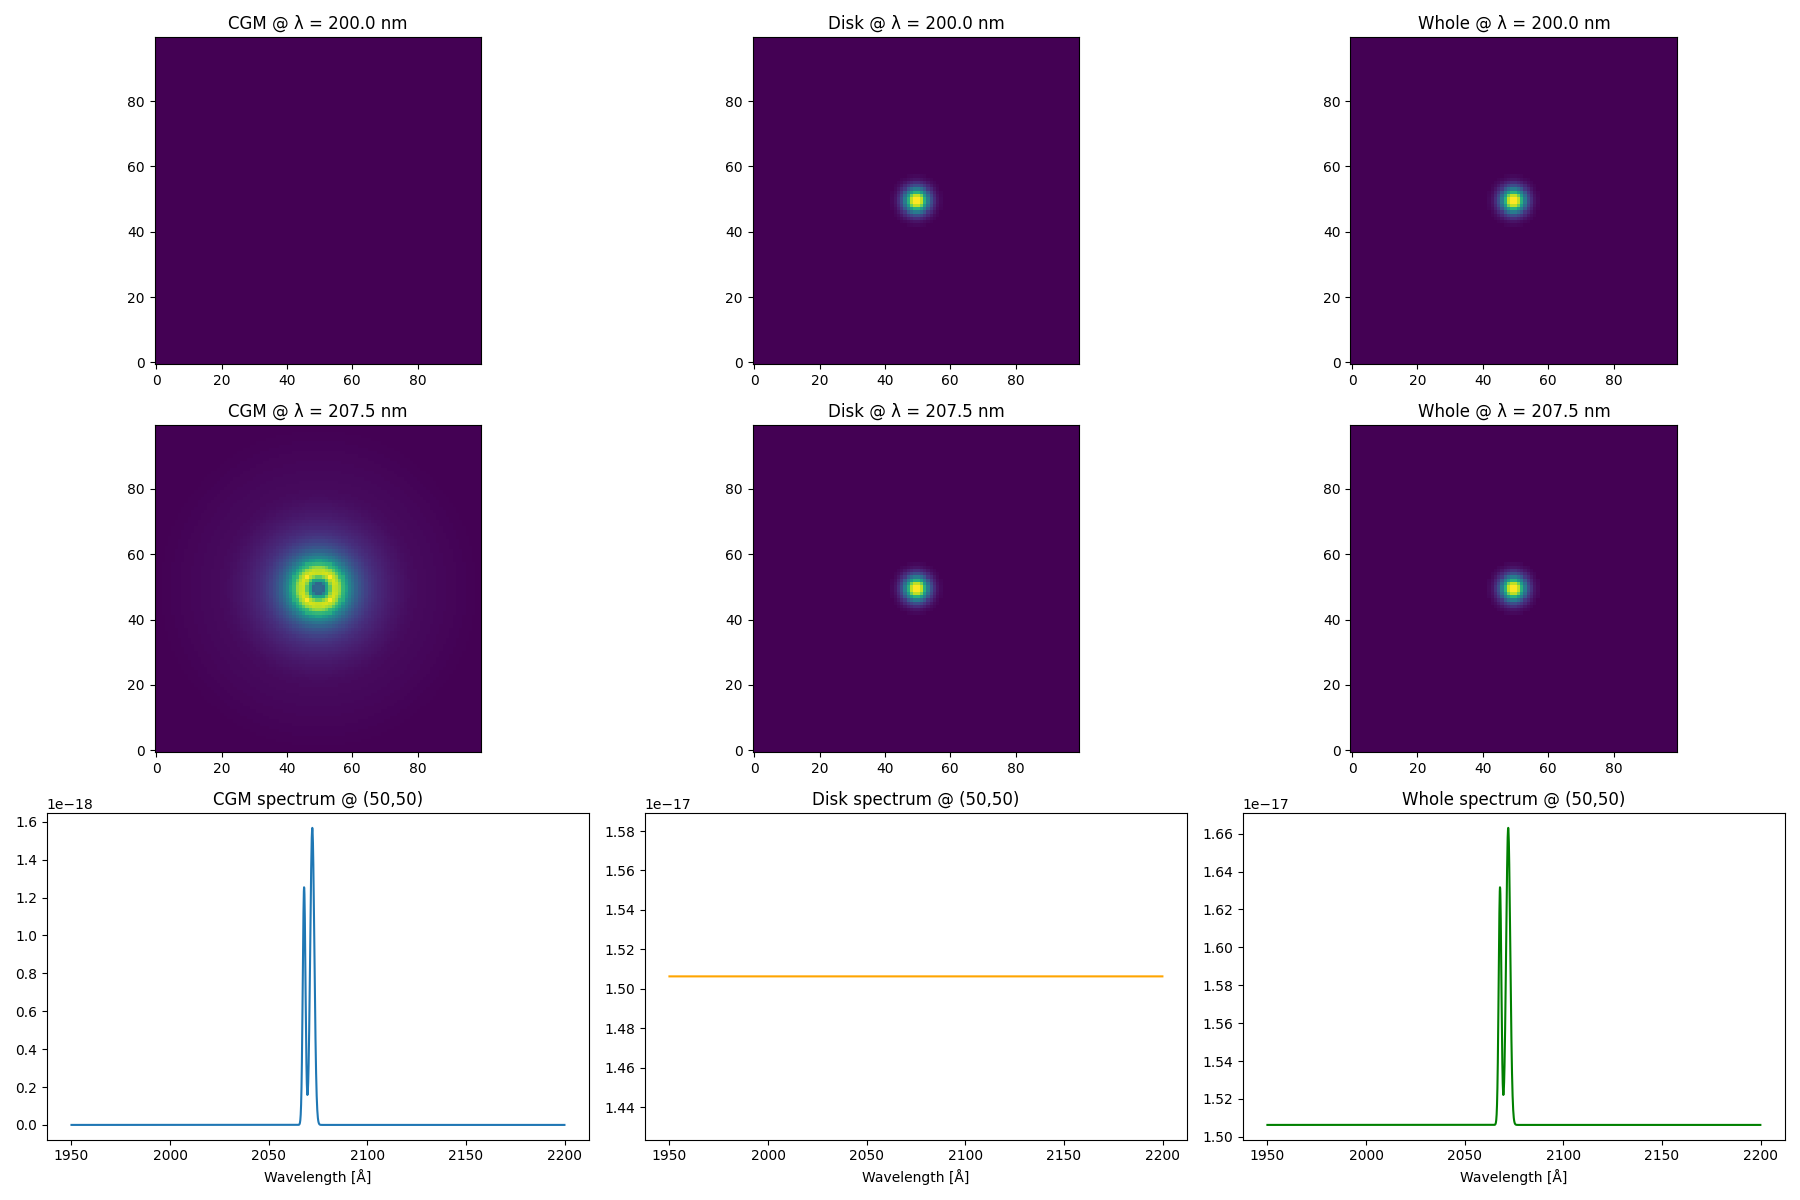

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u

# Load the FITS cube
path = "/Users/Vincent/Github/generic-etc/data/Emission_cube/"
hdu_cgm = fits.open(path + "CGM_cube.fits")[0]
hdu_disk = fits.open(path + "galaxy_disk_cube.fits")[0]
hdu_whole = fits.open(path + "galaxy_and_cgm_cube.fits")[0]

cube_cgm = hdu_cgm.data
cube_disk = hdu_disk.data
cube_whole = hdu_whole.data
wcs = WCS(hdu_cgm.header)

# Extract wavelength axis properly
naxis = cube_cgm.shape[0]
pix = np.arange(naxis)
crval = hdu_cgm.header['CRVAL3']     # Reference wavelength
cdelt = hdu_cgm.header['CDELT3']     # Delta per pixel
crpix = hdu_cgm.header['CRPIX3']     # Reference pixel
cunit = hdu_cgm.header.get('CUNIT3', 'm')  # Default to meters if not defined

# Use astropy.units for proper unit handling
unit = u.Unit(cunit)
wave_axis = (crval + (pix + 1 - crpix) * cdelt) * unit  # wavelength with units
print(wave_axis)
# Convert to nm and Å for display/plotting
wave_nm = wave_axis.to(u.nm).value
wave_angs = wave_axis.to(u.AA).value

# Choose some positions and wavelengths
x, y = 50, 50
idxs = [500, 1250]

# Plotting
fig, axs = plt.subplots(3, 3, figsize=(18, 12))

# Row 1: slices at idx[0]
axs[0, 0].imshow(cube_cgm[idxs[0]], origin='lower', cmap='viridis')
axs[0, 0].set_title(f"CGM @ λ = {wave_nm[idxs[0]]:.1f} nm")

axs[0, 1].imshow(cube_disk[idxs[0]], origin='lower', cmap='viridis')
axs[0, 1].set_title(f"Disk @ λ = {wave_nm[idxs[0]]:.1f} nm")

axs[0, 2].imshow(cube_whole[idxs[0]], origin='lower', cmap='viridis')
axs[0, 2].set_title(f"Whole @ λ = {wave_nm[idxs[0]]:.1f} nm")

# Row 2: slices at idx[1]
axs[1, 0].imshow(cube_cgm[idxs[1]], origin='lower', cmap='viridis')
axs[1, 0].set_title(f"CGM @ λ = {wave_nm[idxs[1]]:.1f} nm")

axs[1, 1].imshow(cube_disk[idxs[1]], origin='lower', cmap='viridis')
axs[1, 1].set_title(f"Disk @ λ = {wave_nm[idxs[1]]:.1f} nm")

axs[1, 2].imshow(cube_whole[idxs[1]], origin='lower', cmap='viridis')
axs[1, 2].set_title(f"Whole @ λ = {wave_nm[idxs[1]]:.1f} nm")

# Row 3: Spectrum at position (x,y)
axs[2, 0].plot(wave_angs, cube_cgm[:, y, x], label='CGM')
axs[2, 0].set_title(f"CGM spectrum @ ({x},{y})")
axs[2, 0].set_xlabel("Wavelength [Å]")

axs[2, 1].plot(wave_angs, cube_disk[:, y, x], label='Disk', color='orange')
axs[2, 1].set_title(f"Disk spectrum @ ({x},{y})")
axs[2, 1].set_xlabel("Wavelength [Å]")

axs[2, 2].plot(wave_angs, cube_whole[:, y, x], label='Whole', color='green')
axs[2, 2].set_title(f"Whole spectrum @ ({x},{y})")
axs[2, 2].set_xlabel("Wavelength [Å]")

plt.tight_layout()
plt.show()

# Create a tab for CGM emission
- Spectra
  - Velocity speed
  - 
- Spatially
  - Continuum 
    - intensity
    - size
  - CGM
    - Instensity
    - Size
